# SNR finder ANN model training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.optimize import curve_fit
from ler.utils import add_dict_values, append_json, get_param_from_json, load_json, save_json
import tensorflow as tf

import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model

from gwsnr import antenna_response_array, cubic_spline_interpolator2d

In [2]:
# # Uncomment to generate new data to test the model

# # generating astrophysical data for testing using `ler` package
# from ler.rates import LeR
# from ler.utils import get_param_from_json

# ler = LeR(verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True, z_max=5)

# size_ = 50000
# ler.batch_size = 50000
# ler.unlensed_cbc_statistics(size=size_, output_jsonfile='unlensed_param_testing.json', resume=True);

In [43]:
# let's generate IMRPhenomD (spinless) interpolartor for the snr_half (refer to gwsnr documentation)
# One of the training input is half_snr
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['L1', 'H1','V1'], ann_partialscaled_approximant='IMRPhenomXPHM')

Interpolator will be generated for L1 detector at ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be generated for H1 detector at ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be generated for V1 detector at ./interpolator_pickle/V1/partialSNR_dict_1.pickle
Please be patient while the interpolator is generated
Generating interpolator for ['L1', 'H1', 'V1'] detectors


interpolation for each mass_ratios: 100%|███████████████████████████| 50/50 [03:44<00:00,  4.48s/it]


Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/AdV_psd.txt', asd_file='None')]


### Input-Output generator function

In [44]:
def input_output(idx, params):
    """
        Function to generate input and output data for the neural network

        Parameters:
        idx: index of the parameter points
        params: dictionary of parameter points
            params.keys() = ['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'psi', 'geocent_time', 'ra', 'dec', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'L1']

        Returns:
        X: input data, [snr_half_[0], amp0[0], eta, chi_eff, theta_jn]
        y: output data, [L1]
    """

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XL1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T
    XH1 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff, theta_jn]).T
    XV1 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff, theta_jn]).T

    # output data
    # get snr for y train
    yL1 = np.array(params['L1'])[idx]
    yH1 = np.array(params['H1'])[idx]
    yV1 = np.array(params['V1'])[idx]
    yNET = np.sqrt(yL1**2 + yH1**2 + yV1**2)

    return(XL1, yL1, XH1, yH1, XV1, yV1, yNET)

## For L1 detector

### Get all necessary data

In [45]:
# these are pre-generated datas
# join all dictionaries into one
# the naming of data files are based on what you have saved. Refer to 'training_data_generation_ann.ipynb' to see how the data is generated with `ler` package and saved.
unlensed_params = get_param_from_json("snr_L1.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
unlensed_params8 = get_param_from_json("joint_new_optsnr_uniform.json")

unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
unlensed_params = add_dict_values(unlensed_params, unlensed_params8)
del unlensed_params8
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7
print(f"size before SNR cut: {len(unlensed_params['L1'])}")
# set SNR cut
idx_constrain = unlensed_params['L1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(f"size after SNR cut: {len(unlensed_params['L1'])}")

size before SNR cut: 428819
size after SNR cut: 417189


In [46]:
len_ = len(unlensed_params['L1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XL1, yL1, _, _, _, _,_ = input_output(idx, unlensed_params)
np.shape(XL1)

(417189, 5)

* It is expected to have larger error in the sparse region of the input data, e.g. $\eta<0.2$

### Scaling the data

In [47]:
X_train, X_test, y_train, y_test = train_test_split(XL1, yL1, test_size = 0.1, random_state = 0)

# Uncomment the following if you have not generated the scaler

# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
pickle.dump(sc, open('scalerL1_final.pkl', 'wb'))

# # Uncomment the following if you have already generated the scaler

# # load the scaler
# scalerL1 = pickle.load(open('scalerL1_final.pkl', 'rb'))
# sc = scalerL1
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

### Generate ANN model

In [48]:
# Uncomment the following if you have already trained the model

# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
# units=5, where 5 is the number of neurons in the first input layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 5s 360us/step - accuracy: 0.0000e+00 - loss: 64.5272
Epoch 2/100
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 358us/step - accuracy: 5.4456e-06 - loss: 5.5053
Epoch 3/100
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 347us/step - accuracy: 8.8220e-06 - loss: 5.2864
Epoch 4/100
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 366us/step - accuracy: 1.2095e-05 - loss: 5.2766
Epoch 5/100
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 348us/step - accuracy: 2.0237e-05 - loss: 4.9760
Epoch 6/100
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 343us/step - accuracy: 1.8278e-05 - loss: 4.9457
Epoch 7/100
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 338us/step - accuracy: 8.8141e-06 - loss: 5.0208
Epoch 8/100
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 344us/step - accuracy: 7.2609e-06 - loss: 5.1035
Epoch 9/100
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 347us/step - accuracy: 9.7776e-06 - loss: 4.9122
Epoch 10/100
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 347us/step - accuracy: 8.4241e-06 - loss: 5.0820
Epoch 11/100
11734/11734 ━━━

In [50]:
# Uncomment the following if you have not trained the model

# Save the model to a file
ann.save('ann_modelL1_final.h5')
modelL1 = ann

# # Uncomment the following if you have already generated the model

# # load the model
# from tensorflow.keras.models import load_model
# modelL1 = load_model('ann_modelL1_final.h5')

### Test the Model on the test data

In [51]:
# left: predicted snr, right: actual snr
y_pred = modelL1.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
[[16.46255302 15.36925853]
 [ 7.34299326  8.1631879 ]
 [18.40270805 19.32192079]
 [ 4.46133804  4.77382202]
 [13.76112938 14.52608943]
 [10.88520241 11.17061064]
 [26.74387932 27.36483974]
 [ 3.37854934  2.72201387]
 [ 4.46126747  4.30502408]
 [ 3.76576853  3.08507739]
 [ 3.33378768  3.29667046]
 [ 4.21110964  3.96505829]
 [ 1.69420433  1.24720302]
 [ 3.82559896  2.41829633]
 [11.03242683 11.02986875]]


In [52]:
# calculate the error
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.89%


### Test with astrophysical parameters

In [53]:
# Get the data. This data is generated using `ler` package.
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")
X_,Y_,_,_,_,_,_ = input_output(np.arange(len(unlensed_params['L1'])), unlensed_params)
scalerL1 = pickle.load(open('scalerL1_final.pkl', 'rb'))
X_ = scalerL1.transform(X_)

modelL1 = load_model('ann_modelL1_final.h5')
y_pred_ = modelL1.predict(X_).flatten()
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
[[49832   105]
 [    4    59]]
Accuracy: 99.782%


### Error analysis

In [64]:
# Uncomment to create error ajustment

# do linear fitting of the error y_pred-y_test
def func(x, a, b):
    return a*x + b

idx = (y_pred_>4) & (y_pred_<10)
idx = idx & (y_test_!=0)
popt, pcov = curve_fit(func, y_pred_[idx], y_pred_[idx]-y_test_[idx])
print(f"slope: {popt[0]:.4f}, intercept: {popt[1]:.4f}")

adjustment_dict = {'slope': popt[0], 'intercept': popt[1]}

# save json
save_json('error_adjustmentL1_final.json', adjustment_dict)

slope: 0.0001, intercept: -0.0075


In [65]:
# load json
adjustment_dict = load_json('error_adjustmentL1_final.json')
a = adjustment_dict['slope']
b = adjustment_dict['intercept']

y_pred_ = modelL1.predict(X_).flatten()
y_pred_ = y_pred_-(a*y_pred_ + b)
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy (after error ajustment): {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
[[49832   105]
 [    4    59]]
Accuracy (after error ajustment): 99.782%


## H1

In [120]:
# the naming of data files are based on what you have saved. Refer to 'training_data_generation_ann.ipynb' to see how the data is generated with `ler` package and saved.

# joint all dict
unlensed_params = get_param_from_json("snr_H1.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
unlensed_params8 = get_param_from_json("joint_new_optsnr_uniform.json")
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
unlensed_params = add_dict_values(unlensed_params, unlensed_params8)
del unlensed_params8
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7
print(f"size before SNR cut: {len(unlensed_params['H1'])}")
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
idx_constrain = unlensed_params['H1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(f"size after SNR cut: {len(unlensed_params['H1'])}")

size before SNR cut: 425469
size after SNR cut: 413822


In [121]:
len_ = len(unlensed_params['H1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
_, _, XH1, yH1, _, _, _ = input_output(idx, unlensed_params)
np.shape(XH1)

(413822, 5)

### Feature scaling

In [122]:
X_train, X_test, y_train, y_test = train_test_split(XH1, yH1, test_size = 0.1, random_state = 0)

# Uncomment the following if you have not generated the scaler

# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
pickle.dump(sc, open('scalerH1_final.pkl', 'wb'))

# # Uncomment the following if you have already generated the scaler

# # load the scaler
# scalerH1 = pickle.load(open('scalerH1_final.pkl', 'rb'))
# sc = scalerH1
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

In [123]:
# Uncomment the following if you have already trained the model

# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
# units=5, where 5 is the number of neurons in the first input layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 338us/step - accuracy: 1.8018e-06 - loss: 81.5036
Epoch 2/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 330us/step - accuracy: 1.4028e-05 - loss: 6.0598
Epoch 3/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 343us/step - accuracy: 3.9449e-06 - loss: 5.3143
Epoch 4/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 337us/step - accuracy: 1.4624e-06 - loss: 5.0010
Epoch 5/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 363us/step - accuracy: 6.1660e-06 - loss: 5.1094
Epoch 6/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 370us/step - accuracy: 0.0000e+00 - loss: 5.0545
Epoch 7/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 338us/step - accuracy: 0.0000e+00 - loss: 4.7952
Epoch 8/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 341us/step - accuracy: 0.0000e+00 - loss: 4.9421
Epoch 9/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 348us/step - accuracy: 1.5122e-05 - loss: 4.8460
Epoch 10/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 347us/step - accuracy: 5.2802e-06 - loss: 4.9224
Epoch 11/100
11639/11639 ━━━

In [130]:
# Uncomment the following if you have not trained the model

# Save the model to a file
ann.save('ann_modelH1_final.h5')
modelH1 = ann

# # Uncomment the following if you have already generated the model

# # load the model
# modelH1 = load_model('ann_modelH1_final.h5')

### Test the Model on the test data

In [131]:
# left: predicted snr, right: actual snr
y_pred = modelH1.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

1294/1294 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
[[ 2.25415564  1.87825041]
 [ 3.34012222  3.53847344]
 [ 9.60850906  9.43302369]
 [ 5.97652388  5.13859978]
 [19.10847282 13.83949988]
 [14.54276085 15.00340638]
 [ 6.51977968  6.65599621]
 [ 4.68445778  4.85796818]
 [ 6.26563549  6.70824177]
 [ 1.70905924  1.80254243]
 [63.90172195 59.5720179 ]
 [ 3.55520535  4.06904557]
 [ 4.11082363  4.00315261]
 [ 2.85332918  2.92882747]
 [ 2.48083162  2.58145873]]


In [132]:
# calculate the error
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 4.11%


### Test with astrophysical parameters

In [133]:
# Get the data. This data is generated using `ler` package.
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")
_, _, X_, Y_, _, _, _ = input_output(np.arange(len(unlensed_params['H1'])), unlensed_params)
scalerH1 = pickle.load(open('scalerH1_final.pkl', 'rb'))
X_ = scalerH1.transform(X_)

modelH1 = load_model('ann_modelH1_final.h5')
y_pred_ = modelH1.predict(X_).flatten()
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
[[49900    45]
 [    8    47]]
Accuracy: 99.894%


### Error analysis

In [140]:
# Uncomment to create error ajustment

# do linear fitting of the error y_pred-y_test
def func(x, a, b):
    return a*x + b

idx = (y_pred_>4) & (y_pred_<10)
idx = idx & (y_test_!=0)
popt, pcov = curve_fit(func, y_pred_[idx], y_pred_[idx]-y_test_[idx])
print(f"slope: {popt[0]:.4f}, intercept: {popt[1]:.4f}")

adjustment_dict = {'slope': popt[0], 'intercept': popt[1]}
# save json
save_json('error_adjustmentH1_final.json', adjustment_dict)

slope: -0.0039, intercept: 0.0193


In [141]:
# load json
adjustment_dict = load_json('error_adjustmentH1_final.json')
a = adjustment_dict['slope']
b = adjustment_dict['intercept']

y_pred_ = modelH1.predict(X_).flatten()
y_pred_ = y_pred_-(a*y_pred_ + b)
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy (after error ajustment): {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
[[49900    45]
 [    8    47]]
Accuracy (after error ajustment): 99.894%


## V1

In [142]:
# these are pre-generated datas
# join all dictionaries into one
# the naming of data files are based on what you have saved. Refer to 'training_data_generation_ann.ipynb' to see how the data is generated with `ler` package and saved.
unlensed_params = get_param_from_json("snr_V1.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
unlensed_params8 = get_param_from_json("joint_new_optsnr_uniform.json")

unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
unlensed_params = add_dict_values(unlensed_params, unlensed_params8)
del unlensed_params8
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7
print(f"size before SNR cut: {len(unlensed_params['V1'])}")
# set SNR cut
idx_constrain = unlensed_params['V1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(f"size after SNR cut: {len(unlensed_params['V1'])}")

size before SNR cut: 409441
size after SNR cut: 400502


In [143]:
len_ = len(unlensed_params['V1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
_, _, _, _, XV1, yV1,_ = input_output(idx, unlensed_params)
np.shape(XV1)

(400502, 5)

### Feature scaling

In [144]:
X_train, X_test, y_train, y_test = train_test_split(XV1, yV1, test_size = 0.1, random_state = 0)

# Uncomment the following if you have not generated the scaler

# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
pickle.dump(sc, open('scalerV1_final.pkl', 'wb'))

# # Uncomment the following if you have already generated the scaler

# # load the scaler
# scalerV1 = pickle.load(open('scalerV1_final.pkl', 'rb'))
# sc = scalerV1
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

### Generate ANN model

In [145]:
# Uncomment the following if you have already trained the model

# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
# units=5, where 5 is the number of neurons in the first input layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 351us/step - accuracy: 2.6724e-05 - loss: 54.9475
Epoch 2/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 346us/step - accuracy: 1.8967e-06 - loss: 5.0122
Epoch 3/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 332us/step - accuracy: 9.8649e-06 - loss: 4.8508
Epoch 4/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 336us/step - accuracy: 1.2657e-05 - loss: 4.9597
Epoch 5/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 333us/step - accuracy: 0.0000e+00 - loss: 4.6671
Epoch 6/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 336us/step - accuracy: 7.8731e-06 - loss: 4.5809
Epoch 7/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 342us/step - accuracy: 2.2992e-05 - loss: 4.6862
Epoch 8/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 334us/step - accuracy: 8.5719e-06 - loss: 4.7661
Epoch 9/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 338us/step - accuracy: 1.5589e-05 - loss: 4.7302
Epoch 10/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 341us/step - accuracy: 8.2987e-06 - loss: 4.7268
Epoch 11/100
11265/11265 ━━━

In [146]:
# Uncomment the following if you have not trained the model

# Save the model to a file
ann.save('ann_modelV1_final.h5')
modelV1 = ann

# # Uncomment the following if you have already generated the model

# # load the model
# from tensorflow.keras.models import load_model
# modelV1 = load_model('ann_modelV1_final.h5')

### Test the Model on the test data

In [147]:
# left: predicted snr, right: actual snr
y_pred = modelV1.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

1252/1252 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
[[ 2.74133778  2.49808277]
 [ 5.26034546  4.78553512]
 [ 3.25269341  2.8022612 ]
 [ 5.23806095  4.74671099]
 [ 1.86369276  1.56265661]
 [ 8.36128235  8.59268207]
 [ 1.94900537  1.56980042]
 [ 2.48335981  3.19269323]
 [ 6.12845612  6.03677146]
 [ 3.78313708  2.99391856]
 [ 5.29105759  5.07915485]
 [13.35671425 13.56670004]
 [ 4.39101124  4.72982666]
 [ 0.90243912  0.54252684]
 [ 4.83383942  4.92850756]]


In [148]:
# calculate the error
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 2.11%


### Test with astrophysical parameters

In [149]:
# Get the data. This data is generated using `ler` package.
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")
_,_,_,_,X_,Y_,_ = input_output(np.arange(len(unlensed_params['V1'])), unlensed_params)
scalerV1 = pickle.load(open('scalerV1_final.pkl', 'rb'))
X_ = scalerV1.transform(X_)

modelV1 = load_model('ann_modelV1_final.h5')
y_pred_ = modelV1.predict(X_).flatten()
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
[[49952    18]
 [    4    26]]
Accuracy: 99.956%


### Error analysis

In [150]:
# Uncomment to create error ajustment

# do linear fitting of the error y_pred-y_test
def func(x, a, b):
    return a*x + b

idx = (y_pred_>4) & (y_pred_<10)
idx = idx & (y_test_!=0)
popt, pcov = curve_fit(func, y_pred_[idx], y_pred_[idx]-y_test_[idx])
print(f"slope: {popt[0]:.4f}, intercept: {popt[1]:.4f}")

adjustment_dict = {'slope': popt[0], 'intercept': popt[1]}
# save json
save_json('error_adjustmentV1_final.json', adjustment_dict)

slope: -0.0383, intercept: 0.5121


In [151]:
# load json
adjustment_dict = load_json('error_adjustmentV1_final.json')
a = adjustment_dict['slope']
b = adjustment_dict['intercept']

y_pred_ = modelV1.predict(X_).flatten()
y_pred_ = y_pred_-(a*y_pred_ + b)
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy (after error ajustment): {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
[[49956    14]
 [    5    25]]
Accuracy (after error ajustment): 99.962%


### L1, H1, V1, NET

### Load the models, scalers and correction functions

In [152]:
# load the ANN models
modelL1 = load_model('ann_modelL1_final.h5')
modelH1 = load_model('ann_modelH1_final.h5')
modelV1 = load_model('ann_modelV1_final.h5')

# load the feature scaler
scalerL1 = pickle.load(open('scalerL1_final.pkl', 'rb'))
scalerH1 = pickle.load(open('scalerH1_final.pkl', 'rb'))
scalerV1 = pickle.load(open('scalerV1_final.pkl', 'rb'))

# load the correction slope and intercept
correctionL1 = load_json('error_adjustmentL1_final.json')
correctionH1 = load_json('error_adjustmentH1_final.json')
correctionV1 = load_json('error_adjustmentV1_final.json')
aL1 = correctionL1['slope']
bL1 = correctionL1['intercept']
aH1 = correctionH1['slope']
bH1 = correctionH1['intercept']
aV1 = correctionV1['slope']
bV1 = correctionV1['intercept']

In [153]:
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")

In [154]:
XL1, yL1, XH1, yH1, XV1, yV1, yNET = input_output(np.arange(len(unlensed_params['optimal_snr_net'])), unlensed_params)

In [155]:
def predict_snr_net_ANN(XL1, XH1, XV1):
    """
        Function to predict the network SNR using the ANN models

        Parameters:
        XL1: input data for L1, [snr_half_[0], amp0[0], eta, chi_eff, theta_jn]
        XH1: input data for H1, [snr_half_[1], amp0[1], eta, chi_eff, theta_jn]
        XV1: input data for V1, [snr_half_[2], amp0[2], eta, chi_eff, theta_jn]

        Returns:
        y: network SNR
    """
    x = scalerL1.transform(XL1)
    yL1 = modelL1.predict(x)
    yL1 = yL1 - (aL1*yL1 + bL1)
    x = scalerH1.transform(XH1)
    yH1 = modelH1.predict(x)
    yH1 = yH1 - (aH1*yH1 + bH1)
    x = scalerV1.transform(XV1)
    yV1 = modelV1.predict(x)
    yV1 = yV1 - (aV1*yV1 + bV1)
    y = np.sqrt(yL1**2 + yH1**2 + yV1**2)

    mass_1 = np.array(unlensed_params['mass_1'])
    mass_2 = np.array(unlensed_params['mass_2'])
    mtot = mass_1 + mass_2
    y[mtot>gwsnr.mtot_max] = 0.

    return(y)

In [156]:
predict_snr_net_ANN(XL1, XH1, XV1).flatten()

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


array([1.3222325, 1.9176006, 1.1828067, ..., 1.2374389, 2.1879537,
       1.3156186], dtype=float32)

In [157]:
# left: predicted snr, right: actual snr
y_pred = predict_snr_net_ANN(XL1, XH1, XV1).flatten()
idx = (y_pred>4) & (y_pred<10)
y_pred_ = y_pred[idx]
y_true_ = yNET[idx]
print(np.concatenate((y_pred_.reshape(len(y_pred_),1), y_true_.reshape(len(y_true_),1)),1))

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step
[[4.62136269 4.74315895]
 [4.31896448 4.41793194]
 [5.00712204 5.29411108]
 ...
 [5.46714211 5.69066226]
 [4.16106319 3.79827401]
 [4.21725225 4.43522929]]


In [158]:
y_pred_ = predict_snr_net_ANN(XL1, XH1, XV1).flatten()
y_test_ = yNET
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
[[49723    28]
 [   24   225]]
Accuracy: 99.896%


### Error analysis

In [122]:
# Uncomment to create error ajustment

# do linear fitting of the error y_pred-y_test
def func(x, a, b):
    return a*x + b

idx = (y_pred_>4) & (y_pred_<10)
idx = idx & (y_test_!=0)
popt, pcov = curve_fit(func, y_pred_[idx], y_pred_[idx]-y_test_[idx])
print(f"slope: {popt[0]:.4f}, intercept: {popt[1]:.4f}")

try:
    adjustment_dict = load_json('error_adjustment_final.json')
except:
    adjustment_dict = {}
adjustment_dict['L1H1V1'] = {'slope': popt[0], 'intercept': popt[1]}
# save json
save_json('error_adjustment_final.json', adjustment_dict)

slope: -0.0027, intercept: 0.1292


In [123]:
# load json
adjustment_dict = load_json('error_adjustment_final.json')
a = adjustment_dict['L1H1V1']['slope']
b = adjustment_dict['L1H1V1']['intercept']

y_pred_ = predict_snr_net_ANN(XL1, XH1, XV1).flatten()
y_pred_ = y_pred_-(a*y_pred_ + b)
y_test_ = yNET
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy (after error ajustment): {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
[[49735    16]
 [   30   219]]
Accuracy (after error ajustment): 99.908%


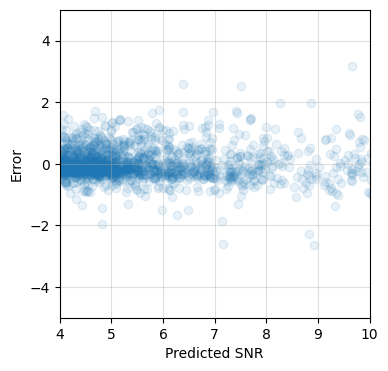

In [124]:
idx = (y_pred_>4) & (y_pred_<12)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_pred_[idx]-y_test_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.xlim(4,10)
plt.ylabel("Error")
plt.ylim(-5,5)
plt.grid(alpha=0.4)
plt.show()

* The error is confined to $\text{SNR}_{-3}^{+3}$, near SNR=8.

In [3]:
dict1= {'a': 1, 'b': 2}
dict2 = {'a': 3, 'c': 4}
dict1.update(dict2)
dict1

{'a': 3, 'b': 2, 'c': 4}

In [4]:
('c' in dict1.keys())

True

In [159]:
ann_path_dict = dict()
ann_path_dict['L1'] = dict(
    model_path='ann_model_L1_O4.h5', 
    scaler_path='scaler_L1_O4.pkl', 
    error_adjustment_path='error_adjustment_L1_O4.json',
    sampling_frequency=2048.0, 
    minimum_frequency=20.0, 
    waveform_approximant='IMRPhenomXPHM', 
    snr_th=8.0
    )
ann_path_dict['H1'] = dict(
    model_path='ann_model_H1_O4.h5', 
    scaler_path='scaler_H1_O4.pkl', 
    error_adjustment_path='error_adjustment_H1_O4.json',
    sampling_frequency=2048.0, 
    minimum_frequency=20.0, 
    waveform_approximant='IMRPhenomXPHM', 
    snr_th=8.0
    )
ann_path_dict['V1'] = dict(
    model_path='ann_model_V1_O4.h5', 
    scaler_path='scaler_V1_O4.pkl', 
    error_adjustment_path='error_adjustment_V1_O4.json',
    sampling_frequency=2048.0, 
    minimum_frequency=20.0, 
    waveform_approximant='IMRPhenomXPHM', 
    snr_th=8.0
    )

In [160]:
import json
# save json
with open('../gwsnr/ann/ann_path_dict.json', 'w') as f:
    json.dump(ann_path_dict, f)

In [161]:
! cp ann_modelL1_final.h5 ../gwsnr/ann/ann_model_L1_O4.h5
! cp scalerL1_final.pkl ../gwsnr/ann/scaler_L1_O4.pkl
! cp ann_modelH1_final.h5 ../gwsnr/ann/ann_model_H1_O4.h5
! cp scalerH1_final.pkl ../gwsnr/ann/scaler_H1_O4.pkl
! cp ann_modelV1_final.h5 ../gwsnr/ann/ann_model_V1_O4.h5
! cp scalerV1_final.pkl ../gwsnr/ann/scaler_V1_O4.pkl
! cp error_adjustmentL1_final.json ../gwsnr/ann/error_adjustment_L1_O4.json
! cp error_adjustmentH1_final.json ../gwsnr/ann/error_adjustment_H1_O4.json
! cp error_adjustmentV1_final.json ../gwsnr/ann/error_adjustment_V1_O4.json